In [1]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from pettingzoo.classic import texas_holdem_v4

# =============== Auxiliary functions related to cards ===============

SUITS = ["Spades", "Hearts", "Diamonds", "Clubs"]
RANKS = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "10", "J", "Q", "K"]

def decode_visible_cards(obs_dict):
    """
    Decode the first 52 bits of the observation vector of texa_holdem_v4 into all the cards that the current player can see
    (Two hand cards + common cards), return [(rank, suit),...] Form.
    """
    vec = np.asarray(obs_dict["observation"]).astype(int)
    card_bits = vec[:52]  # The first 52 dimensions consist of 52 cards
    cards = []
    for idx, bit in enumerate(card_bits):
        if bit == 1:
            suit = SUITS[idx // 13]
            rank = RANKS[idx % 13]
            cards.append((rank, suit))
    return cards


def get_street_from_obs(obs_dict):
    """
    Based on the number of cards currently visible, roughly determine which stage (street) it is in:
    - 2: preflop
    -5: flop
    -6: turn
    7 cards: river
    Return 0/1/2/3
    """
    cards = decode_visible_cards(obs_dict)
    n = len(cards)
    if n <= 2:
        return 0  # preflop
    elif n <= 5:
        return 1  # flop
    elif n <= 6:
        return 2  # turn
    else:
        return 3  # river


def estimate_strength_from_cards(cards):
    """
    A very rough estimate of card power:
        0 = weak
        1 = medium
        2 = strong
    Rule
        - Three or more, or the same pattern (>=5 of the same pattern) -> strong
        - There is A pair, or high cards like Q/K/A appear -> medium
        - Others -> weak
    """
    if not cards:
        return 0

    ranks = [r for (r, s) in cards]
    suits = [s for (r, s) in cards]

    rank_counts = Counter(ranks)
    max_same_rank = max(rank_counts.values())

    suit_counts = Counter(suits)
    max_same_suit = max(suit_counts.values())

    has_high = any(r in ["Q", "K", "A"] for r in ranks)

    # Three flowers/same flower -> strong
    if max_same_rank >= 3 or max_same_suit >= 5:
        return 2

    # A pair or at least one high card -> medium
    if max_same_rank == 2 or has_high:
        return 1

    # others -> weak
    return 0


def encode_state(obs_dict):
    """
    Encode the observation into a very small discrete state:
        street: 0.. 3 (preflop, flop, turn, river)
        strength: 0.. 2 (weak, medium, strong)
    There are a total of 4 * 3 = 12 states, returning an integer of [0, 11].
    """
    street = get_street_from_obs(obs_dict)              # 0..3
    strength = estimate_strength_from_cards(
        decode_visible_cards(obs_dict)
    )                                                   # 0..2
    return street * 3 + strength                        # 0..11


# =============== Rule-based strategy ===============

def pick_legal_action(preferred, legal_actions, backup_order):
    """
    Given a desired action preferred (0/1/2/3), if it is not legal,
    Just find the next legal action in the order of backup_order.
    legal_actions: np.array / list of legal indices
    """
    legal_set = set(int(a) for a in legal_actions)
    if preferred in legal_set:
        return preferred
    for a in backup_order:
        if a in legal_set:
            return a
    # Theoretically, it won't come this far. Just be on the safe side
    return int(list(legal_set)[0])


def rule_based_action(obs_dict, verbose=False, who="player_0"):
    """
    Non-learning rule-based strategies
    First, obtain the street and strength based on observation
    - Use very simple intuitive rules of playing cards to select actions:
        preflop:
            strong -> Raise first; otherwise Call/Check
            medium -> Call first, otherwise Check
            weak -> Check first, otherwise Fold
        flop/turn/river:
            strong  -> Raise > Call > Check
            medium  -> Call > Check
            weak    -> Check > Fold
    Action coding
        0 = Call
        1 = Raise
        2 = Fold
        3 = Check
    """
    mask = np.asarray(obs_dict["action_mask"])
    legal = np.where(mask > 0)[0]

    street = get_street_from_obs(obs_dict)
    cards = decode_visible_cards(obs_dict)
    strength = estimate_strength_from_cards(cards)

    if verbose:
        readable = [f"{r} of {s}" for (r, s) in cards]
        label = ["weak", "medium", "strong"][strength]
        street_name = ["preflop", "flop", "turn", "river"][street]
        print(f"[{who}] street={street_name} cards={readable} | strength={label}")

    # 0=Call, 1=Raise, 2=Fold, 3=Check
    if street == 0:  # preflop
        if strength == 2:      # strong
            action = pick_legal_action(1, legal, backup_order=[0, 3, 2])
        elif strength == 1:    # medium
            action = pick_legal_action(0, legal, backup_order=[3, 1, 2])
        else:                  # weak
            action = pick_legal_action(3, legal, backup_order=[2, 0, 1])
    else:          # flop / turn / river
        if strength == 2:
            action = pick_legal_action(1, legal, backup_order=[0, 3, 2])
        elif strength == 1:
            action = pick_legal_action(0, legal, backup_order=[3, 1, 2])
        else:
            action = pick_legal_action(3, legal, backup_order=[2, 0, 1])

    return int(action)


def play_episode_rule_vs_random(verbose=False):
    """
    Run an entire round of the game
        -player_0 uses the rule-based strategy
        -player_1 Use random legal actions
    Return: The total reward of player_0 (>0 win, <0 loss, =0 draw)
    """
    env = texas_holdem_v4.env()
    env.reset()
    total_reward_p0 = 0.0

    for agent in env.agent_iter():
        obs, reward, termination, truncation, info = env.last()

        # Accumulate the reward of our side (player 0)
        if agent == "player_0":
            total_reward_p0 += reward

        done = termination or truncation
        if done:
            action = None
        else:
            mask = np.asarray(obs["action_mask"])
            legal = np.where(mask > 0)[0]

            if agent == "player_0":
                action = rule_based_action(obs, verbose=verbose, who=agent)
            else:
                # Opponent: Simple random legal action
                action = int(np.random.choice(legal))

        env.step(action)

    env.close()
    return total_reward_p0


def collect_rule_based_stats(num_episodes=1000):
    """
    Run rule-based vs random multiple times to calculate the win rate, etc.
    """
    rewards = []
    for _ in range(num_episodes):
        r = play_episode_rule_vs_random(verbose=False)
        rewards.append(r)

    rewards = np.array(rewards)
    win_rate = np.mean(rewards > 0)
    tie_rate = np.mean(rewards == 0)
    loss_rate = np.mean(rewards < 0)

    print(f"[Rule-based vs Random] over {num_episodes} episodes:")
    print(f"  Win rate : {win_rate:.3f}")
    print(f"  Tie rate : {tie_rate:.3f}")
    print(f"  Loss rate: {loss_rate:.3f}")
    print(f"  Mean reward: {rewards.mean():.3f}")
    return rewards


# =============== Shallow Q-learning（table Q） ===============

def shallow_train(
    num_episodes=5000,
    alpha=0.1,
    gamma=0.9,
    epsilon=0.2,
    epsilon_decay=0.999,
    epsilon_min=0.05,
):
    """
    Perform a very simplified tabular Q-learning on texas_holdem_v4:

    - Control player_0 only
    -player_1 is always a random legal action
    - State space: The 12 states given by encode_state()
    - Action Space: 4 actions (call, raise, fold, check)
    - Reward: Each time it's player_0, env.last() returns "Last time.
        The "reward accumulated after the player_0 action" is used to update the Q table.
    """
    n_states = 12
    n_actions = 4
    Q = np.zeros((n_states, n_actions), dtype=np.float32)

    episode_rewards = []

    for ep in range(num_episodes):
        env = texas_holdem_v4.env()
        env.reset()

        prev_state = None
        prev_action = None
        total_reward_p0 = 0.0

        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()
            done = termination or truncation

            if agent == "player_0":
                # # reward is the earnings since the "last player 0 Action"
                total_reward_p0 += reward

                # 1) Update the previous one (s,a) with the reward seen this time
                if prev_state is not None:
                    current_state = encode_state(obs)
                    # There will be no bootstrapping at the end
                    best_next = 0.0 if done else np.max(Q[current_state])
                    old = Q[prev_state, prev_action]
                    Q[prev_state, prev_action] = (
                        old + alpha * (reward + gamma * best_next - old)
                    )

                # 2) Decide on the action to be done this time
                if done:
                    action = None
                    prev_state = None
                    prev_action = None
                else:
                    state = encode_state(obs)
                    mask = np.asarray(obs["action_mask"])
                    legal_actions = np.where(mask > 0)[0]

                    # epsilon-greedy（Only select from the legal actions）
                    if np.random.rand() < epsilon:
                        action = int(np.random.choice(legal_actions))
                    else:
                        q_row = Q[state].copy()
                        illegal_mask = np.ones_like(q_row, dtype=bool)
                        illegal_mask[legal_actions] = False
                        q_row[illegal_mask] = -1e9
                        action = int(np.argmax(q_row))

                    prev_state = state
                    prev_action = action
            else:
                # Opponent: Random legal action
                if done:
                    action = None
                else:
                    mask = np.asarray(obs["action_mask"])
                    legal_actions = np.where(mask > 0)[0]
                    action = int(np.random.choice(legal_actions))

            env.step(action)

        env.close()

        # Linear decay exploration rate
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        episode_rewards.append(total_reward_p0)

    return Q, np.array(episode_rewards)


def play_episode_q_vs_random(Q, epsilon=0.0, verbose=False):
    """
    Play games using the trained Q-table:
    -player_0: Q table + epsilon-greedy
    -player_1: Random
    """
    env = texas_holdem_v4.env()
    env.reset()
    total_reward_p0 = 0.0

    for agent in env.agent_iter():
        obs, reward, termination, truncation, info = env.last()
        done = termination or truncation

        if agent == "player_0":
            total_reward_p0 += reward

            if done:
                action = None
            else:
                state = encode_state(obs)
                mask = np.asarray(obs["action_mask"])
                legal_actions = np.where(mask > 0)[0]

                if np.random.rand() < epsilon:
                    action = int(np.random.choice(legal_actions))
                else:
                    q_row = Q[state].copy()
                    illegal_mask = np.ones_like(q_row, dtype=bool)
                    illegal_mask[legal_actions] = False
                    q_row[illegal_mask] = -1e9
                    action = int(np.argmax(q_row))
        else:
            if done:
                action = None
            else:
                mask = np.asarray(obs["action_mask"])
                legal_actions = np.where(mask > 0)[0]
                action = int(np.random.choice(legal_actions))

        env.step(action)

    env.close()
    return total_reward_p0


def evaluate_q_policy(Q, num_episodes=1000):
    """
    When evaluating the shallow Q-learning strategy, the opponent remains random.
    Print the win rate/draw rate/expected reward.
    """
    rewards = []
    for _ in range(num_episodes):
        r = play_episode_q_vs_random(Q, epsilon=0.0, verbose=False)
        rewards.append(r)
    rewards = np.array(rewards)

    win_rate = np.mean(rewards > 0)
    tie_rate = np.mean(rewards == 0)
    loss_rate = np.mean(rewards < 0)

    print(f"[Q-learning vs Random] over {num_episodes} episodes:")
    print(f"  Win rate : {win_rate:.3f}")
    print(f"  Tie rate : {tie_rate:.3f}")
    print(f"  Loss rate: {loss_rate:.3f}")
    print(f"  Mean reward: {rewards.mean():.3f}")
    return rewards


In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(episode_rewards, window=50):
    """
    Take the moving average of the episode reward of shallow Q-learning and draw the learning curve.
    """
    rewards = np.asarray(episode_rewards)
    if len(rewards) < window:
        window = len(rewards)
    cumsum = np.cumsum(np.insert(rewards, 0, 0))
    ma = (cumsum[window:] - cumsum[:-window]) / float(window)

    plt.figure(figsize=(8, 4))
    plt.plot(range(window, len(rewards) + 1), ma)
    plt.xlabel("Episode")
    plt.ylabel(f"{window}-episode moving avg reward")
    plt.title("Shallow Q-learning Learning Curve")
    plt.grid(True)
    plt.show()


def plot_q_heatmap(Q):
    """
    Draw the 12x4 Q table as a heat map:
    - Row: 12 discrete states
    Column: Four actions: call/raise/fold/check
    """
    plt.figure(figsize=(8, 5))
    vmin, vmax = -1, 1
    im = plt.imshow(Q, aspect="auto", cmap="Blues", vmin=vmin, vmax=vmax)
    plt.colorbar(im, label="Q-value")
    plt.yticks(range(12), [f"s{idx}" for idx in range(12)])
    plt.xticks(range(4), ["call(0)", "raise(1)", "fold(2)", "check(3)"])
    plt.title("Shallow Q-learning Q-table Heatmap")

    thresh = (vmin + vmax) / 2.0  # 0

    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            val = Q[i, j]
            text_color = "white" if val > thresh else "black"
            plt.text(j, i, f"{val:.2f}",
                     ha="center", va="center",
                     fontsize=7, color=text_color)

    plt.tight_layout()
    plt.show()


def compare_rule_vs_q(rule_rewards, q_rewards):
    """
    A simple comparison between rule-based and shallow Q-learning:
    Print the average reward and win rate of both
    Draw a bar chart of win rate
    """
    rule_rewards = np.asarray(rule_rewards)
    q_rewards = np.asarray(q_rewards)

    def stats(rs):
        return rs.mean(), np.mean(rs > 0)

    m_rule, win_rule = stats(rule_rewards)
    m_q, win_q = stats(q_rewards)

    print("========== Comparison: Rule-based vs Shallow Q-learning ==========")
    print(f"Rule-based: mean reward={m_rule:.3f}, win rate={win_rule:.3f}")
    print(f"Shallow Q:  mean reward={m_q:.3f}, win rate={win_q:.3f}")

    labels = ["Rule-based", "Shallow Q"]
    win_rates = [win_rule, win_q]

    plt.figure(figsize=(5, 4))
    bars = plt.bar(labels, win_rates)
    plt.ylabel("Win rate")
    plt.ylim(0, 1)
    plt.title("Win Rate Comparison vs Random Opponent")
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    # labels
    for bar, val in zip(bars, win_rates):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0,    
            f"{val:.3f}",          
            ha="center",
            va="bottom",
            fontsize=10
        )

    plt.show()


[Rule-based vs Random] over 500 episodes:
  Win rate : 0.582
  Tie rate : 0.002
  Loss rate: 0.416
  Mean reward: 0.460


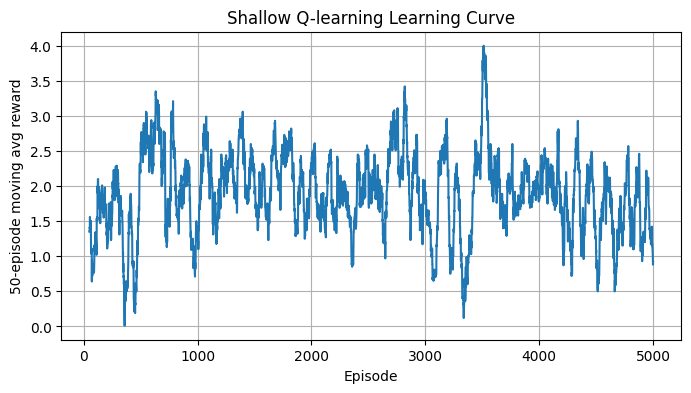

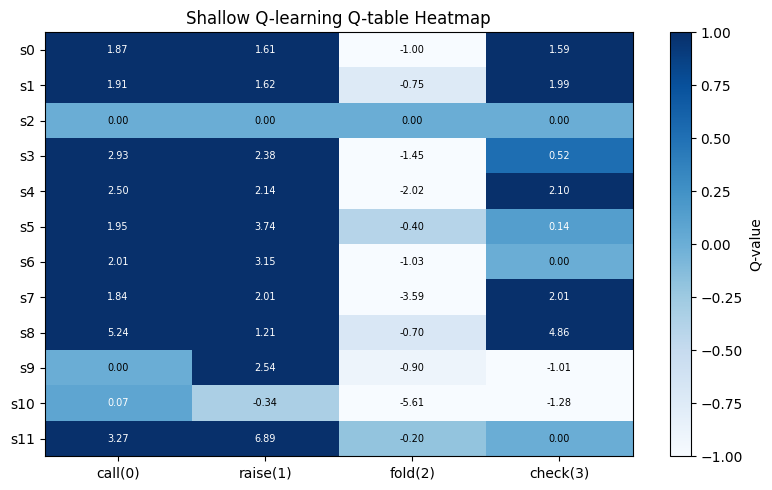

[Q-learning vs Random] over 500 episodes:
  Win rate : 0.928
  Tie rate : 0.002
  Loss rate: 0.070
  Mean reward: 2.002
========== Comparison: Rule-based vs Shallow Q-learning ==========
Rule-based: mean reward=0.460, win rate=0.582
Shallow Q:  mean reward=2.002, win rate=0.928


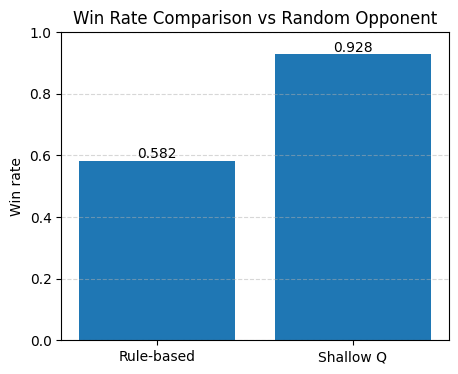

In [13]:
# -------- 1. Run Rule-based baseline --------
rule_rewards = collect_rule_based_stats(num_episodes=500)
# print win/tie/loss 和 mean reward

# -------- 2. Train Shallow Q-learning --------
Q, episode_rewards = shallow_train(num_episodes=5000)

# learning curve
plot_learning_curve(episode_rewards, window=50)

# Q-table heatmap
plot_q_heatmap(Q)

# -------- 3. evaluate Shallow Q-learning --------
q_rewards = evaluate_q_policy(Q, num_episodes=500)

# -------- 4. compare with Rule-based  --------
compare_rule_vs_q(rule_rewards, q_rewards)


In [14]:
def collect_rule_based_action_distribution(num_episodes=300):
    """
    Count the frequency of actions taken by rule-based in multiple episodes.
    Use your existing rule_based_action(), and the environment is also random opponent.
    """
    action_counts = np.zeros(4, dtype=int)  # Corresponding actions: 0/1/2/3

    for ep in range(num_episodes):
        env = texas_holdem_v4.env()
        env.reset()
        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()

            if termination or truncation:
                action = None
            else:
                mask = np.asarray(obs["action_mask"])
                legal = np.where(mask > 0)[0]

                if agent == "player_0":
                    action = rule_based_action(obs, verbose=False)
                else:
                    action = int(np.random.choice(legal))

                if agent == "player_0":
                    action_counts[action] += 1

            env.step(action)
        env.close()

    return action_counts

def plot_rule_based_distribution(counts):
    """
    Plot action distribution of the rule-based policy and annotate each bar
    with its count value.
    """
    labels = ["Call (0)", "Raise (1)", "Fold (2)", "Check (3)"]
    colors = ["steelblue", "tomato", "gray", "green"]

    plt.figure(figsize=(7, 4))
    bars = plt.bar(labels, counts, color=colors)
    plt.title("Rule-based Policy Action Distribution")
    plt.ylabel("Count")
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    for bar, value in zip(bars, counts):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 2,          
            f"{int(value)}",
            ha="center",
            va="bottom",
            fontsize=10
        )

    plt.ylim(0, max(counts) * 1.15)
    plt.tight_layout()
    plt.show()


Action counts: [178  15 121 158]


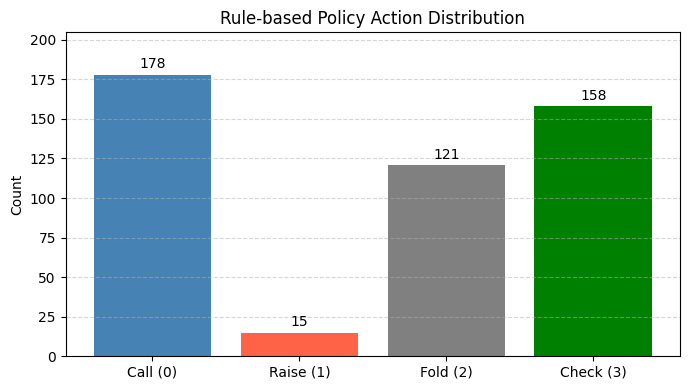

In [15]:
counts = collect_rule_based_action_distribution(num_episodes=300)
print("Action counts:", counts)

plot_rule_based_distribution(counts)


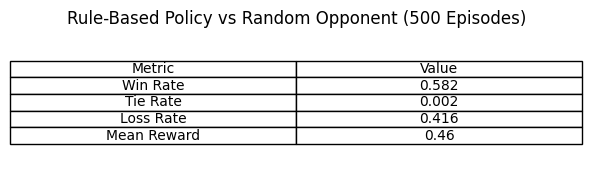

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

data_rule = {
    "Metric": ["Win Rate", "Tie Rate", "Loss Rate", "Mean Reward"],
    "Value":  [0.582,      0.002,      0.416,       0.460]
}

df_rule = pd.DataFrame(data_rule)

fig, ax = plt.subplots(figsize=(6, 1.8))
ax.axis("off")

table = ax.table(
    cellText=df_rule.values,
    colLabels=df_rule.columns,
    cellLoc="center",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.title("Rule-Based Policy vs Random Opponent (500 Episodes)", fontsize=12, pad=15)
plt.tight_layout()
# plt.savefig("table_rule_vs_random.png", dpi=300, bbox_inches="tight")
plt.show()


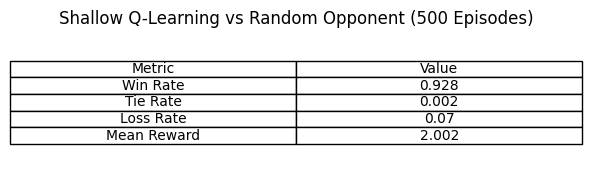

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

data_q = {
    "Metric": ["Win Rate", "Tie Rate", "Loss Rate", "Mean Reward"],
    "Value":  [0.928,      0.002,      0.070,       2.002]
}

df_q = pd.DataFrame(data_q)

fig, ax = plt.subplots(figsize=(6, 1.8))
ax.axis("off")

table = ax.table(
    cellText=df_q.values,
    colLabels=df_q.columns,
    cellLoc="center",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.title("Shallow Q-Learning vs Random Opponent (500 Episodes)", fontsize=12, pad=15)
plt.tight_layout()
# plt.savefig("table_q_vs_random.png", dpi=300, bbox_inches="tight")
plt.show()


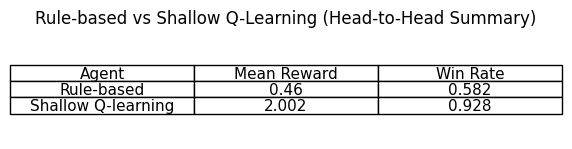

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

data_comp = {
    "Agent":       ["Rule-based", "Shallow Q-learning"],
    "Mean Reward": [0.460,        2.002],
    "Win Rate":    [0.582,        0.928],
}

df_comp = pd.DataFrame(data_comp)

fig, ax = plt.subplots(figsize=(5.8, 1.6))
ax.axis("off")

table = ax.table(
    cellText=df_comp.values,
    colLabels=df_comp.columns,
    cellLoc="center",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.2)

plt.title("Rule-based vs Shallow Q-Learning (Head-to-Head Summary)", fontsize=12, pad=12)
plt.tight_layout()
# plt.savefig("table_rule_vs_q_summary.png", dpi=300, bbox_inches="tight")
plt.show()
